In [3]:
%pip install -r ../requirements.txt

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 33.4 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 10.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 59.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 27.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 11.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.0 MB/s eta

In [4]:
base_dir: bool = False

In [5]:
import os, sys

if not base_dir:
    os.chdir('../')
    base_dir = True

import numpy as np, pandas as pd, matplotlib.pyplot as plt, sklearn, torch

from torch.utils.data import DataLoader, TensorDataset

import torch.nn as nn

from torchvision import datasets, transforms

from sklearn.metrics import accuracy_score

from utils.data_tools import inbreast, cbis_ddsm, image_processing
from utils.models import models

import tensorflow as tf

In [6]:
inbreast.download()
cbis_ddsm.download()

Path not found, downloading!


100%|██████████| 1.91G/1.91G [00:27<00:00, 74.3MB/s]

Extracting files...


Extracting!
Done!
Path not found, downloading!


100%|██████████| 4.95G/4.95G [01:19<00:00, 67.1MB/s]

Extracting files...


Moving!
Done!


In [7]:
# Testing Data, avg time 20 min

class cbis_ddsm_data:

    x_train, x_test, y_train, y_test = data = cbis_ddsm.get_images()

class inbreast_data:

    x_train, x_test, y_train, y_test = data = inbreast.get_images()

    x, y = np.concatenate([x_train, x_test]), np.concatenate([y_train, y_test])

409/409


Pixel Distribution: shape (224, 224), mean 0.218861, std 0.241562, min 0.000000, max 1.000000, unique 231


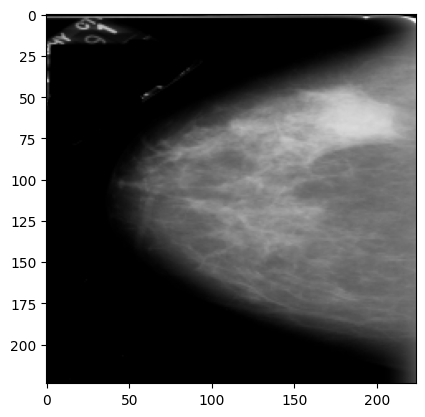

In [8]:
import matplotlib.pyplot as plt

img = cbis_ddsm_data.x_train[0]

print(
    f"Pixel Distribution: shape {img.shape}, mean {np.mean(img):2f}, std {np.std(img):2f}, min {np.min(img):2f}, max {np.max(img):2f}, unique {np.unique(img.flatten()).shape[0]}"
)

plt.imshow(
    img,
    cmap='gray',
)

In [19]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.Grayscale(num_output_channels=1),
    transforms.RandomVerticalFlip(p=0.5),
    transforms.RandomRotation(degrees=(-20, 20)),
    transforms.ToTensor(),
    transforms.Lambda(lambda i: i / i.max()),
])

In [50]:
from PIL import Image
import torch
from torch.utils.data import Dataset

class CustomImageDataset(Dataset):
    def __init__(self, x, y, transform=transform):
        self.x = x
        self.y = y
        self.transform = transform

    def __len__(self):
        return self.x.__len__()

    def __getitem__(self, idx):

        #image = torch.tensor(np.expand_dims(self.x[idx], axis=0), dtype=torch.float32)
        image = self.x[idx]
        if self.transform:
            image = self.transform(Image.fromarray(image))

        label = torch.tensor([0, 1] if self.y[idx] else [1, 0], dtype=torch.float32)

        return image, label

def get_loader(x, y, batch_size=32, transform=transform):

    loader = DataLoader(CustomImageDataset(x, y, transform=transform), batch_size=batch_size, shuffle=True)

    return loader

def get_loader_test(x, y, batch_size=32, transform=transform):

    loader = DataLoader(CustomImageDataset(x, y, transform=transform), batch_size=batch_size)

    return loader

In [51]:
l = get_loader(cbis_ddsm_data.x_train, cbis_ddsm_data.y_train)
vl = get_loader(cbis_ddsm_data.x_test, cbis_ddsm_data.y_test)

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import lightning.pytorch as pl

from torch.utils.data import DataLoader
from torchvision import datasets, transforms

from IPython.display import clear_output

class CNNModel(pl.LightningModule):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 4, kernel_size=5, stride=1, padding=1)
        self.conv2 = nn.Conv2d(4, 8, kernel_size=5, stride=1, padding=1)
        self.conv3 = nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=1)
        self.fc1 = nn.LazyLinear(128)
        self.fc2 = nn.Linear(128, 64)
        self.fc3 = nn.Linear(64, 32)
        self.fc4 = nn.Linear(32, 16)
        self.fc5 = nn.Linear(16, 2)

    def on_train_epoch_end(self):
        clear_output()
        return super().on_train_epoch_end()

    def forward(self, x):
        """
        Returns Logits
        """
        x = torch.relu(self.conv1(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv2(x))
        x = torch.max_pool2d(x, 2)
        x = torch.relu(self.conv3(x))
        x = torch.max_pool2d(x, 2)
        x = torch.flatten(x, 1)
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x))
        x = self.fc5(x)
        return x

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)
        loss = F.cross_entropy(logits, y)
        self.log('train_loss', loss)
        print(f'Train Crossentropy', loss.item())
        print(f'Train Accuracy', (torch.argmax(F.softmax(logits)) == y.long()).count_nonzero() / F.softmax(logits).shape[0])
        return loss

    def val_dataloader(self):
        return get_loader(cbis_ddsm_data.x_test, cbis_ddsm_data.y_test)

    def validation_step(self, batch, batch_idx):
        inputs, targets = batch
        logits = self(inputs)

        loss = F.cross_entropy(logits, targets)

        print(f'Val Crossentropy', loss.item())
        print(f'Val Accuracy', (torch.argmax(F.softmax(logits)) == targets.long()).count_nonzero() / F.softmax(logits).shape[0])
        self.log('val_loss', loss)
        return loss

    def predict_step(self, batch, batch_idx):
        x, y = batch
        logits = self.forward(x)
        predictions = F.softmax(logits, dim=-1)
        return predictions

    def configure_optimizers(self):
        return torch.optim.Adam(self.parameters(), lr=1e-3)


In [53]:
from lightning.pytorch import Trainer
from lightning.pytorch.callbacks import TQDMProgressBar

progress_bar = TQDMProgressBar(refresh_rate=10)

model = CNNModel()
trainer = Trainer(max_epochs=10, enable_progress_bar=False)

trainer.fit(model, l)

INFO: You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO:lightning.pytorch.utilities.rank_zero:You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
  | Name  | Type       | Params | Mode 
---------------------------------------------
0 | conv1 | Conv2d     | 104    | train
1 | conv2 | Conv2d     | 808    | train
2 | conv3 | Conv2d     | 3.2 K  | train
3 | fc1   | LazyLinear | 0      | train
4 | fc2   | Linear     | 8.3 K  | train
5 | fc3   | Linear     

Val Crossentropy nan
Val Accuracy tensor(1.)
Val Crossentropy nan
Val Accuracy tensor(1.)
Train Crossentropy nan
Train Accuracy tensor(0.)


<ipython-input-52-18c44a0524d4>:51: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print(f'Train Accuracy', (torch.argmax(F.softmax(logits)) == y.long()).count_nonzero() / F.softmax(logits).shape[0])


Train Crossentropy nan
Train Accuracy tensor(1.)
Train Crossentropy nan
Train Accuracy tensor(1.)
Train Crossentropy nan
Train Accuracy tensor(1.)
Train Crossentropy nan
Train Accuracy tensor(1.)
Train Crossentropy nan
Train Accuracy tensor(1.)
Train Crossentropy nan
Train Accuracy tensor(1.)
Train Crossentropy nan
Train Accuracy tensor(1.)
Train Crossentropy nan
Train Accuracy tensor(1.)
Train Crossentropy nan
Train Accuracy tensor(1.)
Train Crossentropy nan
Train Accuracy tensor(1.)
Train Crossentropy nan
Train Accuracy tensor(1.)
Train Crossentropy nan
Train Accuracy tensor(1.)


INFO: 
Detected KeyboardInterrupt, attempting graceful shutdown ...
INFO:lightning.pytorch.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined

In [ ]:
testl = get_loader_test(inbreast_data.x, inbreast_data.y)

y_pred = trainer.predict(model, testl)

print(f"""
Test Loss: {F.cross_entropy(torch.concat(y_pred), torch.from_numpy(inbreast_data.y).long())}
Accuracy: {(torch.argmax(torch.concat(y_pred), dim=1) == torch.from_numpy(inbreast_data.y).long()).count_nonzero() / torch.concat(y_pred).shape[0]}
""")

c:\Users\Theon\miniconda3\Lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=15` in the `DataLoader` to improve performance.



Test Loss: 0.3380400538444519
Accuracy: 0.980440080165863     



In [ ]:
torch.save(model.state_dict(), 'models/model_weights.pt')

In [ ]:
os.getcwd()

'c:\\Users\\Theon\\Downloads\\view-prediction'

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=./lightning_logs/